In [26]:
local codebooktxt = '/home/yu/seg_proj/FCN/3d/list/codebook_40.txt' 
codebook = torch.Tensor(40,3)
  local fcode = torch.DiskFile(codebooktxt, 'r')
  for i = 1, 40 do 
    for j = 1, 3 do 
      codebook[{{i},{j}}] = fcode:readFloat()
    end
  end
  fcode:close()


In [27]:
print(codebook)

 0.4960 -0.0328  0.8677
-0.3693  0.6117  0.6996
-0.6709 -0.1876  0.7175
 0.6395  0.4254  0.6404
-0.0101 -0.9997  0.0230
-0.4312 -0.4525  0.7806
-0.3219 -0.0028  0.9468
-0.0364  0.9906  0.1322
-0.9514 -0.0642  0.3012
 0.9995 -0.0019  0.0330
-0.0341  0.9570  0.2881
 0.5758 -0.2533  0.7773
 0.1528  0.9573  0.2453
-0.4765 -0.1713  0.8623
 0.8210  0.5362  0.1958
-0.5933  0.1064  0.7979
 0.6898  0.0317  0.7233
 0.7892 -0.1674  0.5908
-0.1316  0.3189  0.9386
 0.9332 -0.1872  0.3069
 0.2489 -0.0089  0.9685
-0.9990  0.0389 -0.0235
-0.1316 -0.8297  0.5424
 0.4327  0.7867  0.4402
 0.0802 -0.2190  0.9724
 0.6060 -0.7433  0.2833
 0.1358  0.6470  0.7503
-0.2172 -0.2446  0.9450
 0.7004 -0.4333  0.5672
 0.3421 -0.5666  0.7497
-0.7944  0.3807  0.4732
 0.0181  0.8865  0.4623
 0.3295 -0.2642  0.9065
-0.0346 -0.0181  0.9992
-0.4629  0.8400  0.2831
-0.0203 -0.4792  0.8775
 0.3525  0.2934  0.8886
-0.7639 -0.5026  0.4048
 0.8874  0.0649  0.4565
-0.8282 -0.0756  0.5553
[torch.DoubleTensor of size 40x3]



In [5]:
input = image.load('/home/yu/seg_proj/FCN/3d/imgs/bedroom_0052/00000716_rgb.jpg', 3, 'float')   
input = image.scale(input, 512, 512)
input = input * 255
label = image.load('/home/yu/seg_proj/FCN/3d/normals_high/bedroom_0052/00000716_label.jpg', 3, 'float')   
label = image.scale(label, 512, 512)
label = label * 255

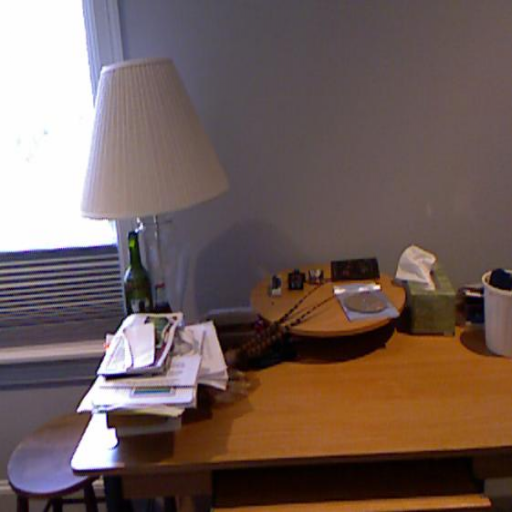

   3
 512
 512
[torch.LongStorage of size 3]



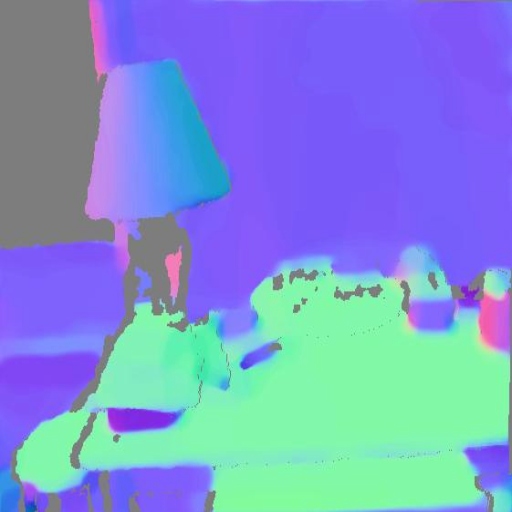

In [6]:
print(#input)
itorch.image(input)
itorch.image(label)
require 'image'
label2 = image.scale(label, 16, 16)
itorch.image(label2)

In [24]:
require 'image'
opt = {}
opt.batchSize = 1
opt.labelSize = 16

function getLabel(input)
    local input_vector = torch.Tensor{input[1], input[2], input[3]}
    local rank = torch.Tensor(40):fill(0)
    _, res_rank = torch.sort(rank:addmv(codebook, input_vector))
    return res_rank[-1]
end

function makeData_cls(img, label)
  -- TODO: the input label is a 3-channel real value image, quantize each pixel into classes (1 ~ 40)
  -- resize the label map from a matrix into a long vector
  -- hint: the label should be a vector with dimension of: opt.batchSize * opt.labelSize * opt.labelSize
  label_cls = torch.Tensor(opt.batchSize * opt.labelSize * opt.labelSize):fill(0)

  for i = 1, opt.batchSize do
      cur_label = image.scale(label[i], opt.labelSize, opt.labelSize)
      for j = 1, opt.labelSize do    -- j -> h
          for z = 1, opt.labelSize do    -- z -> w
              label_cls[(i-1)*opt.labelSize*opt.labelSize + (j-1)*opt.labelSize + z] 
                    = getLabel({cur_label[1][j][z], cur_label[2][j][z], cur_label[3][j][z]})
          end
      end
  end
  return {img, label_cls}
end

In [28]:
img = torch.Tensor(1, 3, 512, 512):fill(0)
lbl = img:clone()
img[1]:copy(input)
lbl[1]:copy(label)
res = makeData_cls(img, lbl)

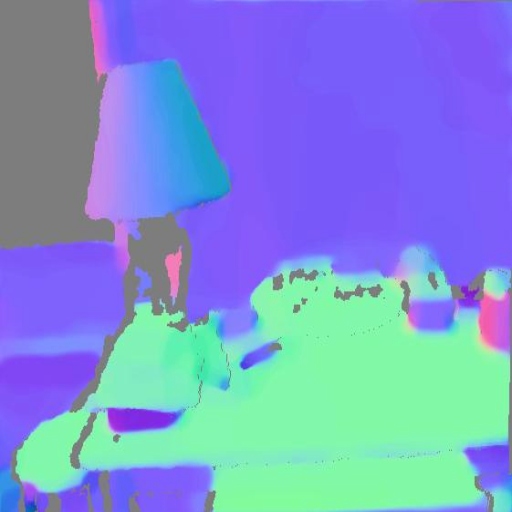

  4   4   4  37  37  37  37  37  37  37  37  37  37  37  37  37
  4   4   4  37  37  37  37  37  37  37  37  37  37  37  37  37
  4   4   4   4  37  27  37  37  37  37  37  37  37  37  37  37
  4   4   4   4  37  27  37  37  37  37  37  37  37  37  37  37
  4   4   4   4  37  27  27  37  37  37  37  37  37  37  37  37
  4   4   4   4  37  27  27  37  37  37  37  37  37  37  37  37
  4   4   4   4  37  37  37  37  37  37  37  37  37  37  37  37
  4   4   4   4   4   4  37  37  37  37  37  37  37  37  37  37
 37  37  37  37   4   4  37  37   4  24   4   4   4  27  37   4
 37  37  37  37  24   4  37  37  24  24  24  24  24  37   4   4
 37  37  37   4  24  24  24   4  24  24  24  24  24  24  24   4
 37  37  37  24  24  24  24  27  24  24  24  24  24  24  24  24
 37  37   4  24  24  24  24  24  24  24  24  24  24  24  24  24
 37  24  24   4   4  24  24  24  24  24  24  24  24  24  24  24
 27  24  24  24   4   4  24  24  24  24  24  24  24  24  24  37
 37   4  37  37  37  37   4  24  24  24 

In [29]:
itorch.image(label)
itorch.image(res[2]:view(16, 16))
print(res[2]:view(16, 16))